In [ ]:
import matplotlib.pyplot as plt #모형 학습시 accuracy와 loss를 저장하기 위한 라이브러리입니다.
import os
import pandas as pd
from keras.preprocessing import image
import json
from glob import glob
import cv2

"""전처리를 위한 라이브러리"""
import os
import pandas as pd

"""Keras 라이브러리"""
import tensorflow.keras as keras #keras 라이브러리입니다.
from tensorflow.keras.preprocessing.image import ImageDataGenerator #이미지 데이터를 tensor로 변한하기 위해 활용되는 라이브러리입니다.
from tensorflow.keras.layers import Dense #학습 모형을 구축하기 위해 활용되는 라이브러리입니다.
from tensorflow.keras import Sequential #학습 모형을 구축하기 위해 활용되는 라이브러리 입니다.
from tensorflow.keras.applications import DenseNet169, VGG16
from tensorflow.keras.callbacks import ModelCheckpoint

import tensorflow as tf
import tensorflow.keras.backend as K

# GPU 디바이스 설정
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
class Import_data:
    def __init__(self, train_path):
        self.train_path = train_path
        self.test_path = val_path

    def train(self):
        # generator 생성
        train_datagen = ImageDataGenerator(rescale=1. / 255,
                                           featurewise_std_normalization=False,
                                           zoom_range=0.2,
                                           channel_shift_range=0.1,
                                           rotation_range=20,
                                           width_shift_range=0.2,
                                           height_shift_range=0.2,
                                           horizontal_flip=True
                                           )
        train_generator = train_datagen.flow_from_directory(
            self.train_path,
            target_size=(224, 224),
            batch_size=8
        )
        val_generator = train_datagen.flow_from_directory(
            self.test_path,
            target_size=(224, 224),
            batch_size=8
        )

        return train_generator, val_generator

### 결막염

In [ ]:
class Fine_tunning:
    def __init__(self, train_path, model_name, epoch):
        self.data = Import_data(train_path)
        self.train_data, self.val_data = self.data.train()
        self.load_model = Load_model(train_path)
        self.epoch = epoch
        self.model_name = model_name
        self.train_path = train_path

    def training(self):
        data_name = self.train_path.split('/')
        data_name = data_name[len(data_name)-2]

        # 옵티마이저 정의
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, decay=1e-5, momentum=0.999, nesterov=True)

        # 모델 생성
        model = self.load_model.build_network()

        # 학습모델 저장할 경로 생성
        save_folder = './model_saved/' + data_name + '/' + self.model_name + '_' + str(self.epoch) + '/'
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)

        # 훈련 중 주기적으로 모델 저장
        check_point = ModelCheckpoint(save_folder + 'model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1,
                                      monitor='val_acc', save_best_only=True, mode='auto')                            
        # 모델 컴파일
        model.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['acc'])

        # 모델 학습
        history = model.fit(
            self.train_data,
            steps_per_epoch=self.train_data.samples / self.train_data.batch_size,
            epochs=self.epoch,
            validation_data=self.val_data,
            validation_steps=self.val_data.samples / self.val_data.batch_size,
            callbacks=[check_point],
            verbose=1)
        return history
    
    def save_accuracy(self, history):
        # 학습모델 저장 경로
        data_name = self.train_path.split('/')
        data_name = data_name[len(data_name)-2]
        save_folder = './model_saved/' + data_name + '/' + self.model_name + '_' + str(self.epoch) + '/'

        acc = history.history['acc']
        val_acc = history.history['val_acc']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(len(acc))
        epoch_list = list(epochs)

        # csv 저장
        df = pd.DataFrame({'epoch': epoch_list, 'train_accuracy': acc, 'validation_accuracy': val_acc},
                          columns=['epoch', 'train_accuracy', 'validation_accuracy'])
        df_save_path = save_folder + 'accuracy.csv'
        df.to_csv(df_save_path, index=False, encoding='euc-kr')

        # Accuracy 그래프 이미지 저장
        plt.plot(epochs, acc, 'b', label='Training acc')
        plt.plot(epochs, val_acc, 'r', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.legend()
        save_path = save_folder + 'accuracy.png'
        plt.savefig(save_path)
        plt.cla()

        # Loss 그래프 이미지 저장
        plt.plot(epochs, loss, 'b', label='Training loss')
        plt.plot(epochs, val_loss, 'r', label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        save_path = save_folder + 'loss.png'
        plt.savefig(save_path)
        plt.cla()

        # 마지막 모델을 제외하고 삭제
        name_list = os.listdir(save_folder)
        h5_list = []
        for name in name_list:
            if '.h5' in name:
                h5_list.append(name)
        h5_list.sort()
        h5_list = [save_folder + name for name in h5_list]
        for path in h5_list[:len(h5_list) - 1]:
            os.remove(path)
        K.clear_session()

In [ ]:
# DenseNet169
class Load_model:
    def __init__(self, train_path):
        self.num_class = len(os.listdir(train_path)) # 클래스 수 

    # 모델 정의
    def build_network(self):
        network = DenseNet169(include_top=True, 
                                    weights='imagenet', 
                                    input_tensor=None, 
                                    input_shape=(224, 224, 3),
                                    pooling='avg')
        model = Sequential()
        model.add(network)
        model.add(Dense(2048, activation='elu'))
        model.add(Dense(self.num_class, activation='sigmoid'))
        model.summary()

        return model

In [ ]:
model_name = 'denseNet169'
epoch = 50

In [ ]:
# 유루증 (데이터 정제 후 모델 테스트)
path='/home/hackerton/Data/Eye2/'
train_path = path + 'Train/Conjunctivitis/'
val_path = path + 'Validation/Conjunctivitis/'

In [ ]:
fine_tunning = Fine_tunning(train_path=train_path,
                                model_name=model_name,
                                epoch=epoch)
history = fine_tunning.training()

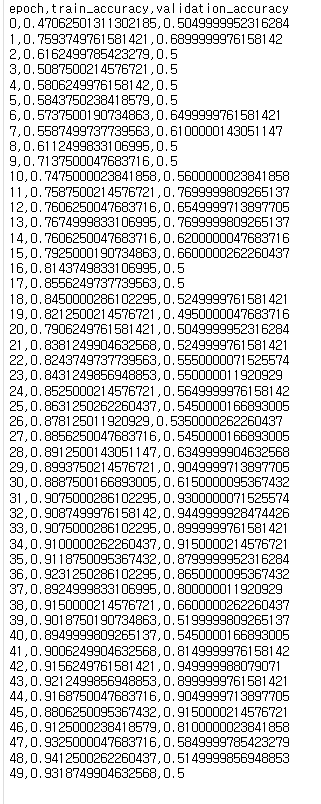

In [ ]:
fine_tunning.save_accuracy(history)

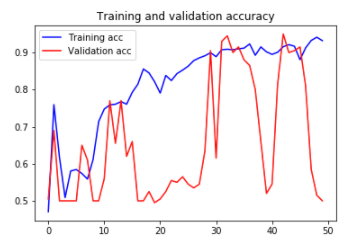

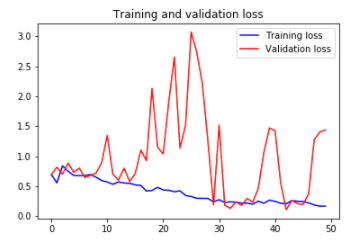

### 유루증

In [ ]:
class Fine_tunning:
    def __init__(self, train_path, model_name, epoch):
        self.data = Import_data(train_path)
        self.train_data, self.val_data = self.data.train()
        self.load_model = Load_model(train_path)
        self.epoch = epoch
        self.model_name = model_name
        self.train_path = train_path

    def training(self):
        data_name = self.train_path.split('/')
        data_name = data_name[len(data_name)-2]

        # 옵티마이저 정의
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, decay=1e-5, momentum=0.999, nesterov=True)

        # 모델 생성
        model = self.load_model.build_network()

        # 학습모델 저장할 경로 생성
        save_folder = './model_saved/' + data_name + '/' + self.model_name + '_' + str(self.epoch) + '/'
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)

        # 훈련 중 주기적으로 모델 저장
        check_point = ModelCheckpoint(save_folder + 'model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1,
                                      monitor='val_acc', save_best_only=True, mode='auto')                            
        # 모델 컴파일
        model.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['acc'])

        # 모델 학습
        history = model.fit(
            self.train_data,
            steps_per_epoch=self.train_data.samples / self.train_data.batch_size,
            epochs=self.epoch,
            validation_data=self.val_data,
            validation_steps=self.val_data.samples / self.val_data.batch_size,
            callbacks=[check_point],
            verbose=1)
        return history
    
    def save_accuracy(self, history):
        # 학습모델 저장 경로
        data_name = self.train_path.split('/')
        data_name = data_name[len(data_name)-2]
        save_folder = './model_saved/' + data_name + '/' + self.model_name + '_' + str(self.epoch) + '/'

        acc = history.history['acc']
        val_acc = history.history['val_acc']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(len(acc))
        epoch_list = list(epochs)

        # csv 저장
        df = pd.DataFrame({'epoch': epoch_list, 'train_accuracy': acc, 'validation_accuracy': val_acc},
                          columns=['epoch', 'train_accuracy', 'validation_accuracy'])
        df_save_path = save_folder + 'accuracy.csv'
        df.to_csv(df_save_path, index=False, encoding='euc-kr')

        # Accuracy 그래프 이미지 저장
        plt.plot(epochs, acc, 'b', label='Training acc')
        plt.plot(epochs, val_acc, 'r', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.legend()
        save_path = save_folder + 'accuracy.png'
        plt.savefig(save_path)
        plt.cla()

        # Loss 그래프 이미지 저장
        plt.plot(epochs, loss, 'b', label='Training loss')
        plt.plot(epochs, val_loss, 'r', label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        save_path = save_folder + 'loss.png'
        plt.savefig(save_path)
        plt.cla()

        # 마지막 모델을 제외하고 삭제
        name_list = os.listdir(save_folder)
        h5_list = []
        for name in name_list:
            if '.h5' in name:
                h5_list.append(name)
        h5_list.sort()
        h5_list = [save_folder + name for name in h5_list]
        for path in h5_list[:len(h5_list) - 1]:
            os.remove(path)
        K.clear_session()

In [ ]:
# DenseNet169
class Load_model:
    def __init__(self, train_path):
        self.num_class = len(os.listdir(train_path)) # 클래스 수 

    # 모델 정의
    def build_network(self):
        network = DenseNet169(include_top=True, 
                                    weights='imagenet', 
                                    input_tensor=None, 
                                    input_shape=(224, 224, 3),
                                    pooling='avg')
        model = Sequential()
        model.add(network)
        model.add(Dense(2048, activation='elu'))
        model.add(Dense(self.num_class, activation='sigmoid'))
        model.summary()

        return model

In [ ]:
model_name = 'denseNet169'
epoch = 50

In [ ]:
# 유루증 (데이터 정제 후 모델 테스트)
path='/home/hackerton/Data/Eye2/'
train_path = path + 'Train/Epiphora/'
val_path = path + 'Validation/Epiphora/'

In [ ]:
fine_tunning = Fine_tunning(train_path=train_path,
                                model_name=model_name,
                                epoch=epoch)
history = fine_tunning.training()

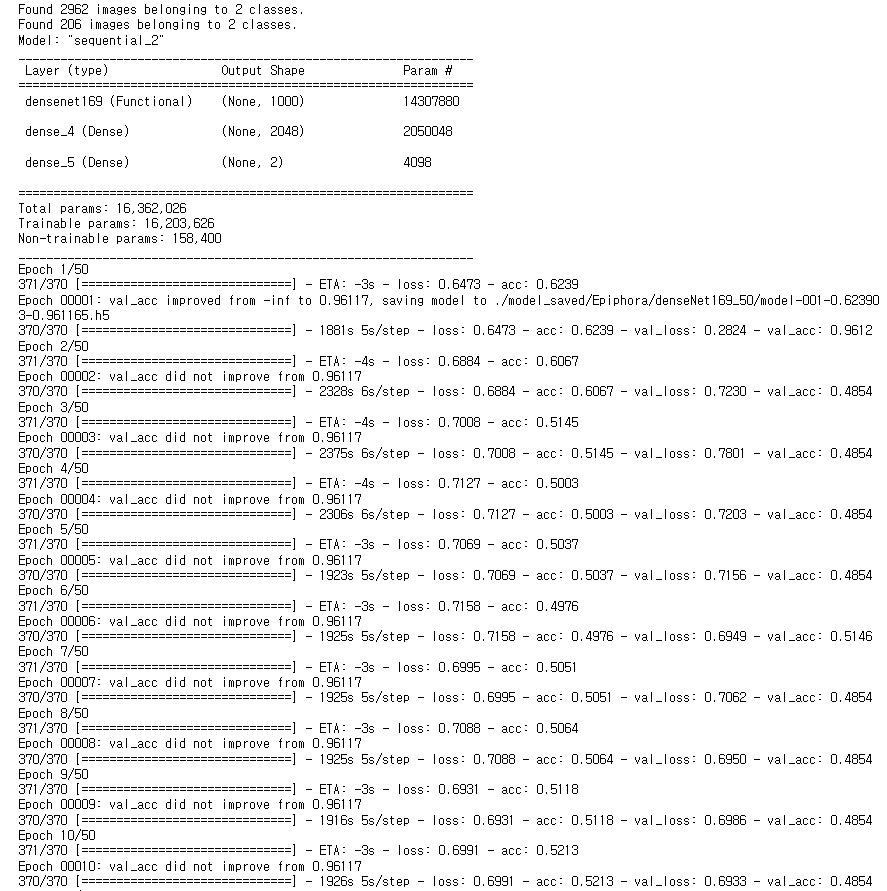

In [ ]:
fine_tunning.save_accuracy(history)

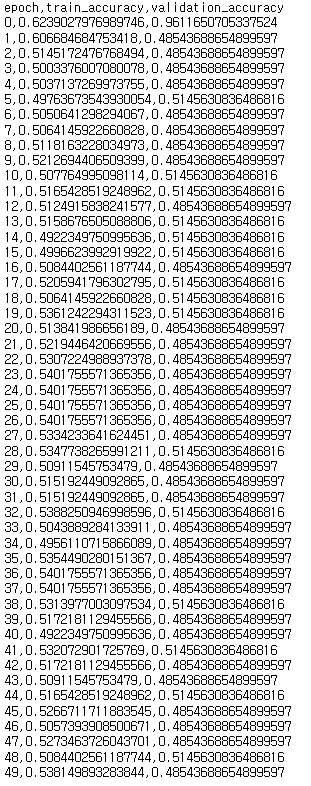

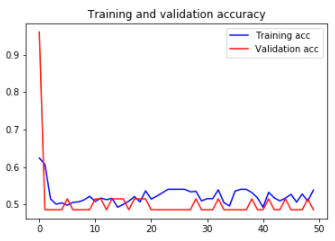

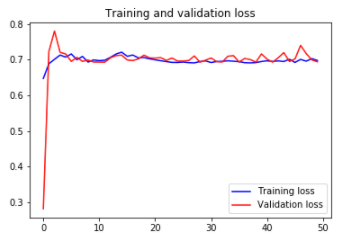

### 안검내반증

In [ ]:
class Fine_tunning:
    def __init__(self, train_path, model_name, epoch):
        self.data = Import_data(train_path)
        self.train_data, self.val_data = self.data.train()
        self.load_model = Load_model(train_path)
        self.epoch = epoch
        self.model_name = model_name
        self.train_path = train_path

    def training(self):
        data_name = self.train_path.split('/')
        data_name = data_name[len(data_name)-2]

        # 옵티마이저 정의
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, decay=1e-5, momentum=0.999, nesterov=True)

        # 모델 생성
        model = self.load_model.build_network()

        # 학습모델 저장할 경로 생성
        save_folder = './model_saved/' + data_name + '/' + self.model_name + '_' + str(self.epoch) + '/'
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)

        # 훈련 중 주기적으로 모델 저장
        check_point = ModelCheckpoint(save_folder + 'model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1,
                                      monitor='val_acc', save_best_only=True, mode='auto')                            
        # 모델 컴파일
        model.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['acc'])

        # 모델 학습
        history = model.fit(
            self.train_data,
            steps_per_epoch=self.train_data.samples / self.train_data.batch_size,
            epochs=self.epoch,
            validation_data=self.val_data,
            validation_steps=self.val_data.samples / self.val_data.batch_size,
            callbacks=[check_point],
            verbose=1)
        return history
    
    def save_accuracy(self, history):
        # 학습모델 저장 경로
        data_name = self.train_path.split('/')
        data_name = data_name[len(data_name)-2]
        save_folder = './model_saved/' + data_name + '/' + self.model_name + '_' + str(self.epoch) + '/'

        acc = history.history['acc']
        val_acc = history.history['val_acc']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(len(acc))
        epoch_list = list(epochs)

        # csv 저장
        df = pd.DataFrame({'epoch': epoch_list, 'train_accuracy': acc, 'validation_accuracy': val_acc},
                          columns=['epoch', 'train_accuracy', 'validation_accuracy'])
        df_save_path = save_folder + 'accuracy.csv'
        df.to_csv(df_save_path, index=False, encoding='euc-kr')

        # Accuracy 그래프 이미지 저장
        plt.plot(epochs, acc, 'b', label='Training acc')
        plt.plot(epochs, val_acc, 'r', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.legend()
        save_path = save_folder + 'accuracy.png'
        plt.savefig(save_path)
        plt.cla()

        # Loss 그래프 이미지 저장
        plt.plot(epochs, loss, 'b', label='Training loss')
        plt.plot(epochs, val_loss, 'r', label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        save_path = save_folder + 'loss.png'
        plt.savefig(save_path)
        plt.cla()

        # 마지막 모델을 제외하고 삭제
        name_list = os.listdir(save_folder)
        h5_list = []
        for name in name_list:
            if '.h5' in name:
                h5_list.append(name)
        h5_list.sort()
        h5_list = [save_folder + name for name in h5_list]
        for path in h5_list[:len(h5_list) - 1]:
            os.remove(path)
        K.clear_session()

In [ ]:
# DenseNet169
class Load_model:
    def __init__(self, train_path):
        self.num_class = len(os.listdir(train_path)) # 클래스 수 

    # 모델 정의
    def build_network(self):
        network = DenseNet169(include_top=True, 
                                    weights='imagenet', 
                                    input_tensor=None, 
                                    input_shape=(224, 224, 3),
                                    pooling='avg')
        model = Sequential()
        model.add(network)
        model.add(Dense(2048, activation='elu'))
        model.add(Dense(self.num_class, activation='sigmoid'))
        model.summary()

        return model

In [ ]:
model_name = 'denseNet169'
epoch = 50

In [ ]:
# 안구내반증 (데이터 정제 후 모델 테스트)
path='/home/hackerton/Data/Eye2/'
train_path = path + 'Train/Entropion/'
val_path = path + 'Validation/Entropion/'

In [ ]:
fine_tunning = Fine_tunning(train_path=train_path,
                                model_name=model_name,
                                epoch=epoch)
history = fine_tunning.training()

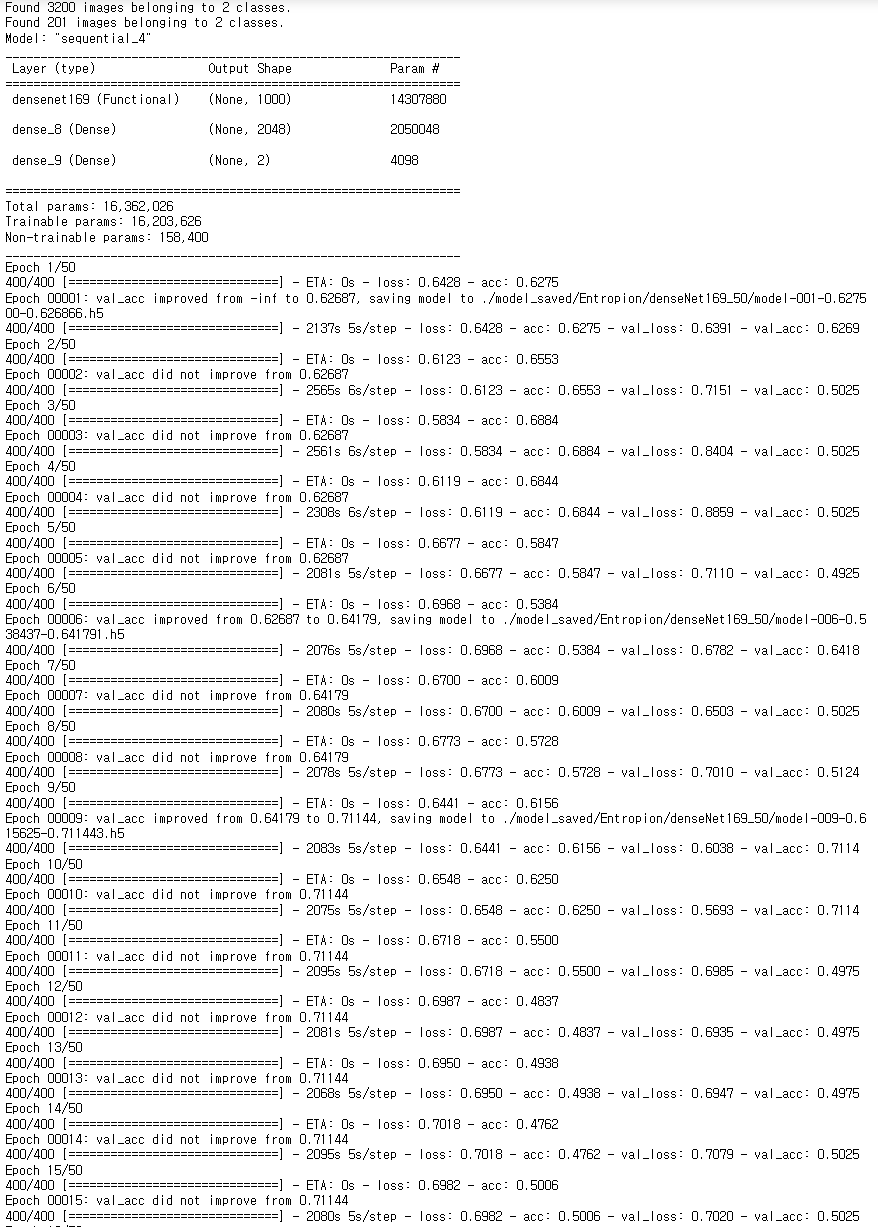

In [ ]:
fine_tunning.save_accuracy(history)

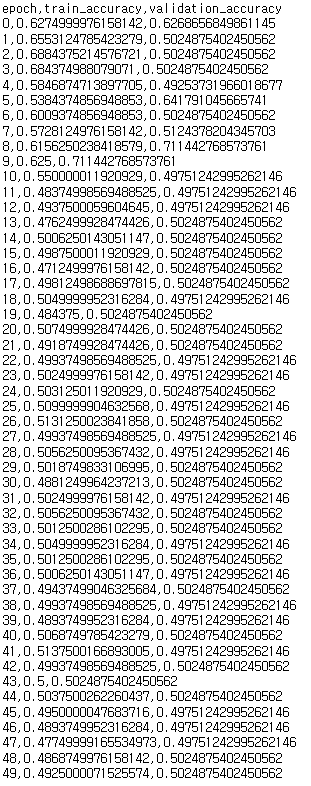

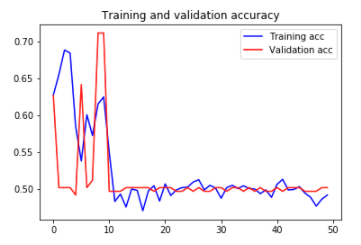

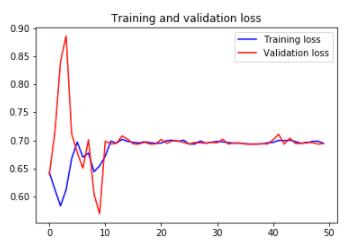

### 백내장

In [ ]:
# 백내장 모델링
# DenseNet169
class Load_model:
    def __init__(self, train_path):
        self.num_class = len(os.listdir(train_path)) # 클래스 수 

    # 모델 정의
    def build_network(self):
        network = DenseNet169(include_top=True, 
                                    weights='imagenet', 
                                    input_tensor=None, 
                                    input_shape=(224, 224, 3),
                                    pooling='avg')
        model = Sequential()
        model.add(network)
        model.add(Dense(2048, activation='elu'))
        model.add(Dense(self.num_class, activation='softmax'))
        model.summary()

        return model

In [ ]:
class Fine_tunning:
    def __init__(self, train_path, model_name, epoch):
        self.data = Import_data(train_path)
        self.train_data, self.val_data = self.data.train()
        self.load_model = Load_model(train_path)
        self.epoch = epoch
        self.model_name = model_name
        self.train_path = train_path

    def training(self):
        data_name = self.train_path.split('/')
        data_name = data_name[len(data_name)-2]

        # 옵티마이저 정의
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, decay=1e-5, momentum=0.999, nesterov=True)

        # 모델 생성
        model = self.load_model.build_network()

        # 학습모델 저장할 경로 생성
        save_folder = './model_saved/' + data_name + '/' + self.model_name + '_' + str(self.epoch) + '/'
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)

        # 훈련 중 주기적으로 모델 저장
        check_point = ModelCheckpoint(save_folder + 'model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1,
                                      monitor='val_acc', save_best_only=True, mode='auto')                            
        # 모델 컴파일
        model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['acc'])

        # 모델 학습
        history = model.fit(
            self.train_data,
            steps_per_epoch=self.train_data.samples / self.train_data.batch_size,
            epochs=self.epoch,
            validation_data=self.val_data,
            validation_steps=self.val_data.samples / self.val_data.batch_size,
            callbacks=[check_point],
            verbose=1)
        return history
    
    def save_accuracy(self, history):
        # 학습모델 저장 경로
        data_name = self.train_path.split('/')
        data_name = data_name[len(data_name)-2]
        save_folder = './model_saved/' + data_name + '/' + self.model_name + '_' + str(self.epoch) + '/'

        acc = history.history['acc']
        val_acc = history.history['val_acc']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(len(acc))
        epoch_list = list(epochs)

        # csv 저장
        df = pd.DataFrame({'epoch': epoch_list, 'train_accuracy': acc, 'validation_accuracy': val_acc},
                          columns=['epoch', 'train_accuracy', 'validation_accuracy'])
        df_save_path = save_folder + 'accuracy.csv'
        df.to_csv(df_save_path, index=False, encoding='euc-kr')

        # Accuracy 그래프 이미지 저장
        plt.plot(epochs, acc, 'b', label='Training acc')
        plt.plot(epochs, val_acc, 'r', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.legend()
        save_path = save_folder + 'accuracy.png'
        plt.savefig(save_path)
        plt.cla()

        # Loss 그래프 이미지 저장
        plt.plot(epochs, loss, 'b', label='Training loss')
        plt.plot(epochs, val_loss, 'r', label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        save_path = save_folder + 'loss.png'
        plt.savefig(save_path)
        plt.cla()

        # 마지막 모델을 제외하고 삭제
        name_list = os.listdir(save_folder)
        h5_list = []
        for name in name_list:
            if '.h5' in name:
                h5_list.append(name)
        h5_list.sort()
        h5_list = [save_folder + name for name in h5_list]
        for path in h5_list[:len(h5_list) - 1]:
            os.remove(path)
        K.clear_session()

In [ ]:
model_name = 'DenseNet169'
epoch = 50

In [ ]:
# 백내장 (데이터 정제 후 모델 테스트)
path='/home/hackerton/Data/Eye2/'
train_path = path + 'Train/Cataract/'
val_path = path + 'Validation/Cataract/'

In [ ]:
fine_tunning = Fine_tunning(train_path=train_path,
                                model_name=model_name,
                                epoch=epoch)
history = fine_tunning.training()

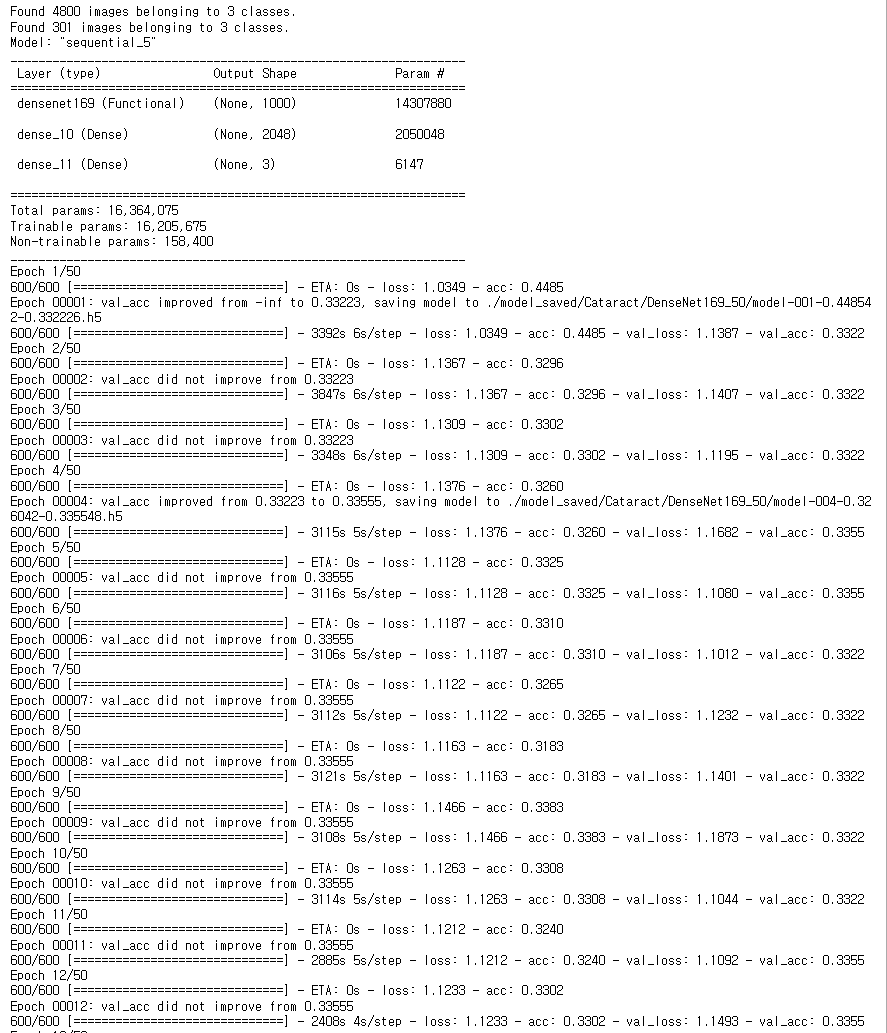

In [ ]:
fine_tunning.save_accuracy(history)

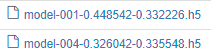

### 모델 일부 Test

In [ ]:
from keras.models import load_model

In [ ]:
os.listdir('/home/hackerton/Data/Eye2/Test/' + eye_name[0] + '/')

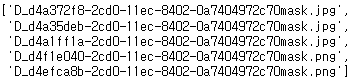

In [ ]:
# model 검증 (결막염 이용 - 5개 test 셋으로 분류 확인)
model_path='/home/hackerton/jupyter/model_saved/Conjunctivitis/denseNet169_50/'
model=load_model(model_path+'model-043-0.915625-0.950000.h5') 

In [ ]:
save_folder2='/home/hackerton/Data/Eye2/Test/'
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1. / 255,
                                   featurewise_std_normalization=False,
                                   zoom_range=0.2,
                                   channel_shift_range=0.1,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True
                                   )
test_generator = test_datagen.flow_from_directory(
            save_folder2,
            target_size=(224, 224),
            batch_size=8
        )

In [ ]:
test_generator.reset()
cls_test = test_generator.classes
cls_pred = model.predict_generator(test_generator, verbose=1, workers=0)
cls_pred_argmax = cls_pred.argmax(axis=1)

In [ ]:
cls_test

In [ ]:
cls_pred

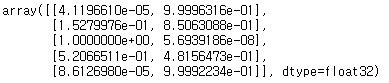

In [ ]:
cls_pred_argmax

In [ ]:
from sklearn import metrics
report = metrics.classification_report(y_true=cls_test, y_pred=cls_pred_argmax, target_names=['normal', 'abnormal'])
#report = pd.DataFrame(report).transpose()

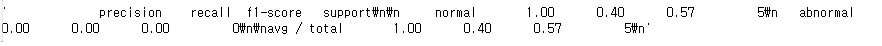